#Part 5: fit GLM and use as input to HDDM

In this last part we will fit a GLM to the fMRI data and use the parameters we estimate to link the neural data to the drift diffusion model

In [339]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import scipy as sp
from scipy import stats
%matplotlib inline

### Get the signals

We use a glob and regular experssion to get the data:

In [340]:
import glob
import re

In [341]:
fns = glob.glob('/data/extracted_signals/extracted_timeseries/_mask_*_subject_id_*/_extracter*/*.txt')
fns[:10]

['/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_0483/_extracter0/pp0483_B1_dtype_mcf_mask_gms_tempfilt_warp_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_0483/_extracter1/pp0483_B2_dtype_mcf_mask_gms_tempfilt_warp_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_R_subject_id_0553/_extracter0/pp0553_B1_dtype_mcf_mask_gms_tempfilt_warp_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_R_subject_id_0553/_extracter1/pp0553_B2_dtype_mcf_mask_gms_tempfilt_warp_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_0197/_extracter0/pp0197_B1_dtype_mcf_mask_gms_tempfilt_warp_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_0197/_extracter1/pp0197_B2_dtype_mcf_mask_gms_tempfilt_warp_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_0551/_extracter0/pp0551_B1_dtype_mcf_mask_gms_tempfilt_warp_ts.txt',
 '/data/extracted_signals/e

1) What does the following code do?

In [342]:
reg = re.compile('.*/_mask_(?P<mask>.*)_subject_id_(?P<subj_idx>.*)/_extracter[0-9]/.*_B(?P<block>[0-9])_dtype_mcf_mask_gms_tempfilt_warp_ts.txt')

In [343]:
for fn in fns[:5]:
    print fn, reg.match(fn).groupdict()

/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_0483/_extracter0/pp0483_B1_dtype_mcf_mask_gms_tempfilt_warp_ts.txt {'subj_idx': '0483', 'mask': 'STR_L', 'block': '1'}
/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_0483/_extracter1/pp0483_B2_dtype_mcf_mask_gms_tempfilt_warp_ts.txt {'subj_idx': '0483', 'mask': 'STR_L', 'block': '2'}
/data/extracted_signals/extracted_timeseries/_mask_STR_R_subject_id_0553/_extracter0/pp0553_B1_dtype_mcf_mask_gms_tempfilt_warp_ts.txt {'subj_idx': '0553', 'mask': 'STR_R', 'block': '1'}
/data/extracted_signals/extracted_timeseries/_mask_STR_R_subject_id_0553/_extracter1/pp0553_B2_dtype_mcf_mask_gms_tempfilt_warp_ts.txt {'subj_idx': '0553', 'mask': 'STR_R', 'block': '2'}
/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_0197/_extracter0/pp0197_B1_dtype_mcf_mask_gms_tempfilt_warp_ts.txt {'subj_idx': '0197', 'mask': 'STR_L', 'block': '1'}


Let's put everything in a large dataframe:

In [344]:
df = []

for fn in fns:
    d = reg.match(fn).groupdict()
    d['signal'] = np.loadtxt(fn)
    df.append(d)
    
df = pandas.DataFrame(df)
df['block'] = df['block'].astype(int)
df['subj_idx'] = df['subj_idx'].astype(int)

2) Have a look at the head of the dataframe, what do you see? Can you plot the signal for a few subjects?

In [345]:
df

,block,mask,signal,subj_idx
0,1,STR_L,"[-8.262414933, 6.395576764, -23.70604471, -15....",483
1,2,STR_L,"[8.46078402, -4.054066721, 30.41606345, 37.158...",483
2,1,STR_R,"[-0.1760025031, 54.6030405, 49.77598952, 39.83...",553
3,2,STR_R,"[-18.53217572, 1.719660699, 16.76373175, -6.66...",553
4,1,STR_L,"[-32.27034141, -27.29804682, -25.59760089, -12...",197
5,2,STR_L,"[57.67064588, 113.4375781, 76.77986256, 26.889...",197
6,1,STR_L,"[-46.17725772, -9.045052082, -30.84334848, -65...",551
7,2,STR_L,"[-37.37061246, -36.52424222, -21.79381393, -0....",551
8,1,STR_R,"[-37.27095632, -26.62397819, -19.58466272, -28...",551
9,2,STR_R,"[-42.48003882, -32.81134667, -11.87963014, -8....",551


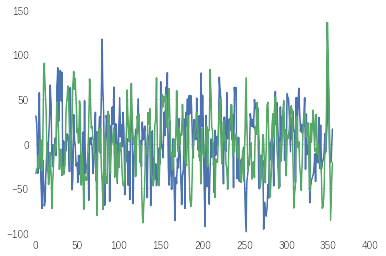

In [346]:
plt.plot(df.signal.ix[66])
plt.plot(df.signal.ix[4])

In [347]:
sp.stats.pearsonr(df.signal.ix[66], df.signal.ix[4])

(0.0097140333270300319, 0.8552804322622668)

Now we are gonna use nipy to set up a design matrix for the GLM

In [348]:
from nipy.modalities.fmri import design_matrix, experimental_paradigm


Let's start with an example:

In [349]:
conditions = ['condition1'] * 3 + ['condition2'] * 3
onsets = [5, 25 , 35, 15, 30, 40]


tr = 2.0
frametimes = np.arange(0, 50, 2)
hrf_model = 'Canonical'

paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                onset=onsets,
                                                duration=[[1.]] * len(conditions))


X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, )

1) Plot matrix X. What do you see? What are the 'conditions' and 'onsets'?

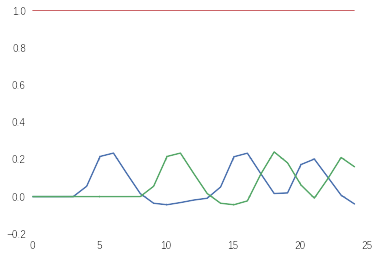

In [350]:
plt.plot(X)

Now let's make the GLM for an actual subject

In [351]:
behavior = pandas.load('/data/behavior-v2.pandas')

Let's go for subject 548, block 1, left Striatum

In [352]:
subj_idx = 548
block = 1
mask = 'STR_L'

# Select only onsets of subject subj_idx and block block
d = behavior[(behavior.subj_idx == subj_idx) & (behavior.block == block)]

# Make a list of conditions
conditions = ['accuracy'] * (d.cond == '1').sum() +  ['speed'] * (d.cond == '2').sum()

# Make a list of onsets
onsets = d[d.cond == '1'].cue_onset.tolist() + d[d.cond == '2'].cue_onset.tolist()


# The number of volumes is 355, the time is 355*2 = 710, in steps of TR seconds (2)
tr = 2.0
frametimes = np.arange(0, 710, tr)
hrf_model = 'Canonical'

# Set up paradigm
paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                onset=onsets,
                                                duration=[[2.]] * len(conditions))

# Set up GLM
X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='blank')
X = pandas.DataFrame(X, columns=names)

2) Plot X again, how does it look?

Now we can fit the GLM using ordinary least squares (OLS)

In [353]:
import statsmodels.api as sm
Y = df[(df.subj_idx == subj_idx) & (df.block == block) & (df['mask'] == mask)].iloc[0].signal
model = sm.OLS(Y, X)
r = model.fit()
r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     26.75
Date:                Tue, 02 Jun 2015   Prob (F-statistic):           1.53e-11
Time:                        09:39:17   Log-Likelihood:                -1623.5
No. Observations:                 355   AIC:                             3253.
Df Residuals:                     352   BIC:                             3265.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
accuracy      19.9825      8.632      2.315      0.021         3.006    36.959
speed         61.2510      8.432      7.264      0.000        44.668    77.834
constant      -4.5229      1.445     -3.129      0.002        -7.365    -1.680
==============================================================================
Omnibus:                        1.475   Durbin-Watson:                   1.088
Prob(Omnibus):                  0.478   Jarque-Bera (JB):                1.225
Skew:                           0.119   Prob(JB):                        0.542
Kurtosis:                       3.162   Cond. No.                         7.54
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

3) Interpret these resuts. What do you see?

4) Now write a [function](http://www.tutorialspoint.com/python/python_functions.htm) that, given a subject_id and a block fits the glm and returns a dataframe with parameter estimates (hint: most of this is just copying the code above).

In [354]:
r.params

accuracy    19.982537
speed       61.250953
constant    -4.522942
dtype: float64

In [355]:
def fit_glm(subj_idx, block, mask):
    
    # Select only onsets of subject subj_idx and block block
    d = behavior[(behavior.subj_idx == subj_idx) & (behavior.block == block)]

    # Make a list of conditions
    conditions = ['accuracy'] * (d.cond == '1').sum() +  ['speed'] * (d.cond == '2').sum()

    # Make a list of onsets
    onsets = d[d.cond == '1'].cue_onset.tolist() + d[d.cond == '2'].cue_onset.tolist()


    # The number of volumes is 355, the time is 355*2 = 710, in steps of TR seconds (2)
    # signal...
    Y = df[(df.subj_idx == subj_idx) & (df.block == block) & (df['mask'] == mask)].iloc[0].signal
    
    tr = 2.0
    frametimes = np.arange(0, Y.shape[0] * 2, tr)
    hrf_model = 'Canonical'
    
    #print frametimes

    # Set up paradigm
    paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                    onset=onsets,
                                                    duration=[[2.]] * len(conditions))

    # Set up GLM
    X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='blank')
    X = pandas.DataFrame(X, columns=names)
    model = sm.OLS(Y, X)
    r = model.fit()
    
    return r.params
    

In [356]:

fit_glm(548, 1, 'STR_R')

accuracy     9.676504
speed       45.783643
constant    -3.099225
dtype: float64

Now we can loop through the signals and fit the GLM, storing it in a dataframe

In [357]:
results = []

for fn in fns:
    subj_idx = int(reg.match(fn).groupdict()['subj_idx'])
    block = int(reg.match(fn).groupdict()['block'])
    for mask in ['STR_L', 'STR_R']:
        r = fit_glm(subj_idx, block, mask)
        
        for condition in ['accuracy', 'speed']:
            d = {}
            d['subj_idx'] = subj_idx
            d['mask'] = mask
            d['block'] = block
            d['condition'] = condition
            d['value'] = r[condition]
            results.append(d)

results = pandas.DataFrame(results)

5) Have a look at the dataframe 'results' and use factorplot to summarize it

In [358]:
results.head()

,block,condition,mask,subj_idx,value
0,1,accuracy,STR_L,483,38.363305
1,1,speed,STR_L,483,113.680204
2,1,accuracy,STR_R,483,19.249807
3,1,speed,STR_R,483,90.794544
4,2,accuracy,STR_L,483,24.669389


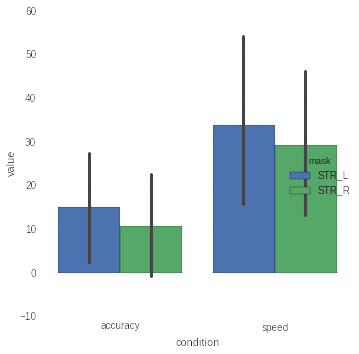

In [359]:
sns.factorplot('condition', 'value', 'mask', data=results, units='subj_idx')

6) Interpret the results

Now we can use pivot_table to get a difference-value for every subjects

In [361]:
neural_results = results.pivot_table(values='value', columns=['condition', 'mask'], index=['subj_idx'])
neural_results

condition   accuracy                  speed           
mask           STR_L      STR_R       STR_L      STR_R
subj_idx                                              
197        20.297497  28.775511   35.399893  32.502410
372       -25.206397 -23.708943  -28.198138 -27.848169
381         2.763836   4.301661    5.919840  20.403582
471        46.246059  33.034205   30.175990  28.648976
483        31.516347  18.047887   89.656101  66.441784
498        34.883485  36.852975   34.854594  21.491018
523        26.397715   9.251906    6.635653   7.699153
544       -47.424435 -48.665150  -14.017671 -21.149068
548        26.345839  18.681974   41.404691  25.468869
549        -7.207777  -9.667304   -4.723258  16.371287
551        29.159076  19.939847   66.966463  59.314449
552        27.666736  20.928980   52.360642  43.882645
553         1.818046   9.226789   64.771731  58.872309
554        61.081503  49.867041  117.139668  97.489322
555        -8.091450  -7.678153    8.928049   3.391889
558        24.944020  10.308571   56.611616  55.945742
559        11.679212  13.318509    9.504244   7.174765

7) What happened here?

Now let's load the hddm parameters

In [362]:
hddm_pars = pandas.load('/data/results_hddm.pandas')

In [363]:
hddm_pars.head(15)

,parameter,value
0,a(1),1.909120
1,a(2),0.968345
2,a_std,0.310148
3,a_rate(1),19.847083
4,a_rate(2),10.066847
5,a_shape(1),37.890469
6,a_shape(2),9.748179
7,a_subj(1).197,2.093290
8,a_subj(1).372,2.315100
9,a_subj(1).381,1.395888


The following code is a bit hacky, a way to get the threshold-estimates out

In [364]:
import re
reg = re.compile('a_subj\((?P<condition>[0-9])\)\.(?P<subj_idx>[0-9]{3})')

results = []

for i, row in hddm_pars.iterrows():
    if row.parameter[:6] == 'a_subj':
        d = reg.match(row.parameter).groupdict()
        d['value'] = row.value
        results.append(d)
        
threshold_pars = pandas.DataFrame(results)
threshold_pars['condition'] = threshold_pars.condition.map({'1':'accuracy', '2':'speed'})
threshold_pars['subj_idx'] = threshold_pars['subj_idx'].astype(int) 

In [365]:
behavioral_results = threshold_pars.pivot_table(values='value', columns='condition', index=['subj_idx'])
behavioral_results

condition,accuracy,speed
subj_idx,,
197,2.093290,0.767477
372,2.315100,0.886336
381,1.395888,0.994500
471,2.051854,0.731500
483,2.111730,0.811064
498,1.746325,0.839810
523,2.100895,0.864003
544,2.041006,0.952433
548,1.902495,0.899980


Now we merge the behavioral and neural results

In [368]:
combined_data = pandas.merge(neural_results, behavioral_results, suffixes=('_fmri', '_threshold'), left_index=True, right_index=True)
combined_data

,"(accuracy, STR_L)","(accuracy, STR_R)","(speed, STR_L)","(speed, STR_R)",accuracy,speed
subj_idx,,,,,,
197,20.297497,28.775511,35.399893,32.502410,2.093290,0.767477
372,-25.206397,-23.708943,-28.198138,-27.848169,2.315100,0.886336
381,2.763836,4.301661,5.919840,20.403582,1.395888,0.994500
471,46.246059,33.034205,30.175990,28.648976,2.051854,0.731500
483,31.516347,18.047887,89.656101,66.441784,2.111730,0.811064
498,34.883485,36.852975,34.854594,21.491018,1.746325,0.839810
523,26.397715,9.251906,6.635653,7.699153,2.100895,0.864003
544,-47.424435,-48.665150,-14.017671,-21.149068,2.041006,0.952433
548,26.345839,18.681974,41.404691,25.468869,1.902495,0.899980


8) What does the table above contain?

9) Correlate the difference in thresholds with the difference in fMRI signals using lmplot for left and right striatum

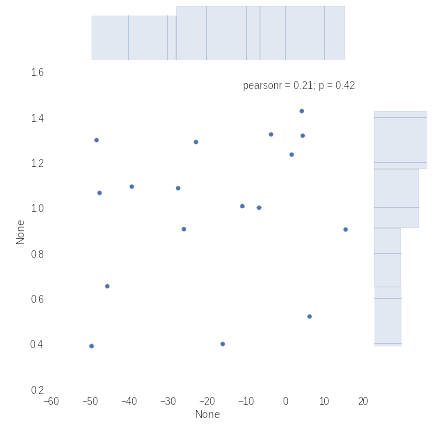

In [372]:
sns.jointplot(combined_data[('accuracy', 'STR_R')] - combined_data[('speed', 'STR_R')], combined_data['accuracy'] - combined_data['speed'])

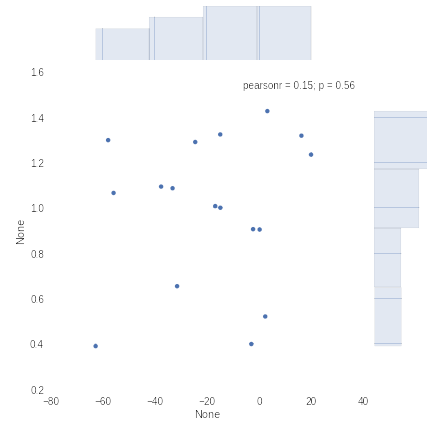

In [373]:
sns.jointplot(combined_data[('accuracy', 'STR_L')] - combined_data[('speed', 'STR_L')], combined_data['accuracy'] - combined_data['speed'])